# CNN Image Classifier

## Project Details

The objective of the project is to build a Convolutional Neural Network (CNN) model from scratch to classify images from a given dataset into predefined categories. 

Then, implement a transfer learning approach using a pre-trained model. 

Finally, compare the performance of the custom CNN and the transfer learning model based on evaluation metrics and analysis.

## Data Set Details

### Animals-10

Dataset that contains 28K medium quality animal pictures of 10 different categories (dog, cat, horse, spyder, butterfly, chicken, sheep, cow, squirrel, elephant) taken from google images

**URL**: https://www.kaggle.com/datasets/alessiocorrado99/animals10/data \
**Author**: [Corrado Alessio](https://www.kaggle.com/alessiocorrado99)

## Set-up

### Dependencies

In [2]:
#$ pip install -r requirements.txt

In [1]:
# Required to manage the dataset
import requests
import zipfile
import os
import shutil
import gc

# Required to manage images
from PIL import Image
import hashlib

# Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Deep Learing
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

2025-06-16 08:38:08.198800: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-16 08:38:09.199170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-16 08:38:09.251186: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-16 08:38:09.301850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-16 08:38:09.728559: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Custom functions
%load_ext autoreload
%autoreload 2
from helpers import *

### Define parameters

In [3]:
# Reduce image size to normalize them and also because of memory usage
img_height = 100
img_width  = 100

model_compare = []

seed = 42

### Settings

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Make the models deterministic
set_seed(seed)

### Download Dataset

In [5]:
# Dowloading and preparing dataset (since it will not be included on the github repo)
url   = "https://www.kaggle.com/api/v1/datasets/download/alessiocorrado99/animals10"
base_dir = "./dataset"
ds_dir = base_dir + "/raw-img" # Is the folder of this dataset containing the pictures

if not os.path.isdir(base_dir):
    os.makedirs(base_dir)

if not os.path.isdir(ds_dir):
    print("Dataset is not present (starting download)")
    lfile = base_dir  + "/" + url.split('/')[-1]
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(lfile, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):  
                f.write(chunk)

    with zipfile.ZipFile(lfile, 'r') as zip_ref:
        zip_ref.extractall(base_dir)
    os.remove(lfile)
    print("Dataset ready")
else:
    print("Dataset is already present (no need for download)")

Dataset is not present (starting download)
Dataset ready


### Prepare the dataset

In [6]:
# Import translations (ITA to ENG) for the labels provided in the dataset
from dataset.translate import translate

# prepare the dataset
img_data = []
for folder in os.listdir(ds_dir):
    images = os.listdir(ds_dir + '/' + folder)
    for image in images:
        path = ds_dir + '/' + folder + '/' + image

        with Image.open(path) as img:
            # I'll use this to validate there are not repeated images
            imghash = hashlib.sha1(img.tobytes()).hexdigest() 
            # Translate labels (translations don't follow all the same format some are ITA:ENG but some are ENG:ITA)
            label = translate[folder] if folder in translate else list(translate.keys())[list(translate.values()).index(folder)] if folder in list(translate.values()) else folder
            # I am going to add a feature to know if image is portrait, landscape or squared
            orientation =  "portrait" if int(img.size[0] <  img.size[1]) else "landscape" if int(img.size[0] >  img.size[1]) else "squared"

            img_data.append({'img': image, 'hash': imghash, 'width': img.size[0], 'height': img.size[1], 'mode': img.mode, 'format':img.format, 'palette':img.palette, 'orientation':orientation, 'path': path, 'label': label})

img_df = pd.DataFrame(img_data)  
img_df    

,img,hash,width,height,mode,format,palette,orientation,path,label
0,OIP-Gpa-3M-3IyJoYATOst0QHgHaHa.jpeg,bf7cb056645f0031e69a52aedd0d0480c286a26b,300,300,RGB,JPEG,None,squared,./dataset/raw-img/farfalla/OIP-Gpa-3M-3IyJoYAT...,butterfly
1,e832b70c2af0043ed1584d05fb1d4e9fe777ead218ac10...,3e9dad45c26c3deb96ffea72f12d2128c77050aa,640,640,RGB,JPEG,None,squared,./dataset/raw-img/farfalla/e832b70c2af0043ed15...,butterfly
2,ea36b20d2bf6083ed1584d05fb1d4e9fe777ead218ac10...,3a3ef400ebae7605cc0dcb3ebc840cad0463066b,640,480,RGB,JPEG,None,landscape,./dataset/raw-img/farfalla/ea36b20d2bf6083ed15...,butterfly
3,OIP-OYm86z-SuQPW_v8_fnzJYQHaFH.jpeg,758e7961d853872f5cfd7fb045b68f083b94f328,300,207,RGB,JPEG,None,landscape,./dataset/raw-img/farfalla/OIP-OYm86z-SuQPW_v8...,butterfly
4,OIP-sB8f5rvtA8Rvais3C20drwHaE7.jpeg,41df709171bf1bc36f1df0b8af10cbe77205d5a8,300,200,RGB,JPEG,None,landscape,./dataset/raw-img/farfalla/OIP-sB8f5rvtA8Rvais...,butterfly
...,...,...,...,...,...,...,...,...,...,...
26174,OIP-8V8StkVgXPGi18csjmEjegHaFh.jpeg,6292e559c0b76293ebaa5aee1ce01c4cd12759df,300,224,RGB,JPEG,None,landscape,./dataset/raw-img/elefante/OIP-8V8StkVgXPGi18c...,elephant
26175,OIP-0XAbxzMOUSY1EF0JR5UI4gHaE4.jpeg,f0c93d60976a61697fb5e00ddb3225d608440609,300,198,RGB,JPEG,None,landscape,./dataset/raw-img/elefante/OIP-0XAbxzMOUSY1EF0...,elephant
26176,OIP-V8MYzpyMKhYC9KgXO6YmKgHaG-.jpeg,b1595586aac367b720e22a8c1059541f582ee318,300,283,RGB,JPEG,None,landscape,./dataset/raw-img/elefante/OIP-V8MYzpyMKhYC9Kg...,elephant
26177,OIP-SrbEBzRGqYXhOo1FYeoyRQHaFr.jpeg,47f8c3b727f8781aea47be2d0e301ba2eb0d7cf3,300,230,RGB,JPEG,None,landscape,./dataset/raw-img/elefante/OIP-SrbEBzRGqYXhOo1...,elephant


Are the all the images unique?:  True


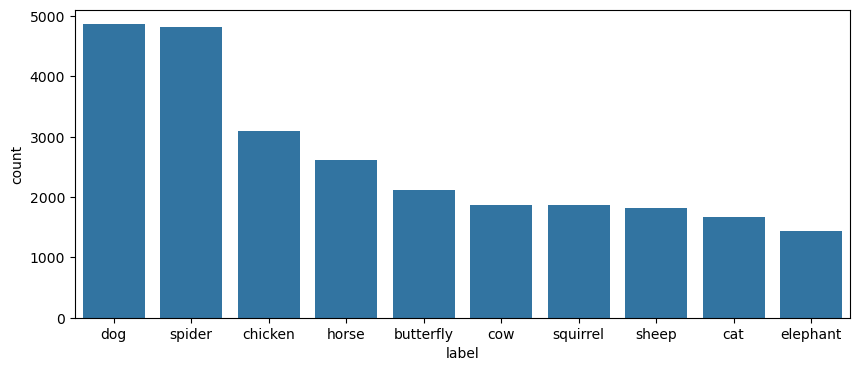

,count,proportion
label,,
dog,4863,0.19
spider,4821,0.18
chicken,3098,0.12
horse,2623,0.10
butterfly,2112,0.08
cow,1866,0.07
squirrel,1862,0.07
sheep,1820,0.07
cat,1668,0.06


In [7]:
# Validate all images are unique
print("Are the all the images unique?: ", img_df["hash"].unique().size == img_df.shape[0])

# Check labels frequency
cat_analisis(img_df, "label", log=False, top=False, bottom=False, chart_size=(10,4))

**Analysis:**

I've read the information of the images and I checked if there were no duplicates and also the dataset distribution.\
An Exploratory Data Analysis must be performed in oder to identify how to balance the labels in the dataset but also to know what to do with the resolution of the images (I see there are different size images). \
Before doing that, I am going to write a funciton that allows me to import the images from the DataFrame I just created in Train, Test and Validate and make a fist model to be able to compare later.

## First Model

### 1. Data Preprocessing

- Data loading and preprocessing (e.g., normalization, resizing, augmentation).
- Create visualizations of some images, and labels.

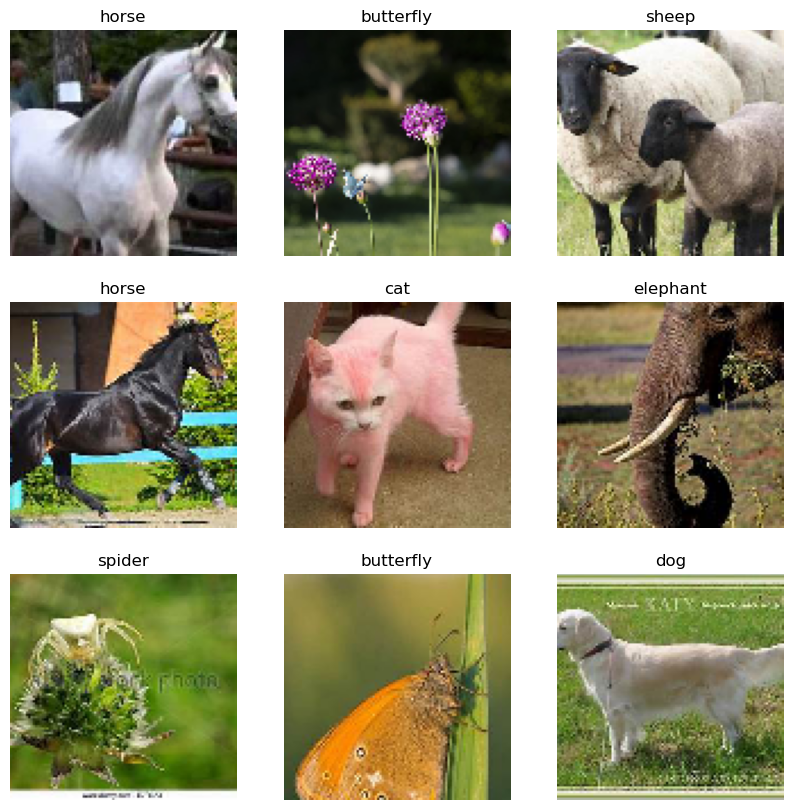

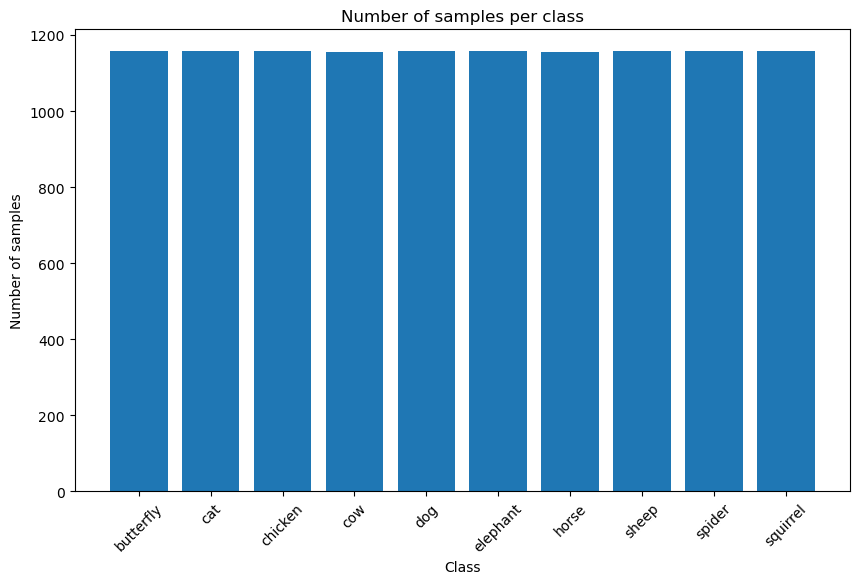

Training data shape X:  (11568, 100, 100, 3) , y: (11568,)
Test data shape X:  (2892, 100, 100, 3) , y: (2892,)


In [8]:
# I am goint to balance the model by taking the first items of each category
df_01 = balance_labels(img_df, label_colum="label", shuffle=True, seed=seed)

X, y, class_names = get_img_xy(df=df_01, path_column = "path", label_column = "label", img_width=img_width, img_height=img_height, color_mode="rgb", seed=seed)
ds1_X_train, ds1_X_test, ds1_y_train, ds1_y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=seed)

# Preview Data
preview_img_dataset_xy(ds1_X_train, ds1_y_train, class_names)

# Preview Data Distribution
show_labels_distribution(labels = ds1_y_train, class_names = class_names)

# Review Shapes
print("Training data shape X: ", ds1_X_train.shape, ", y:", ds1_y_train.shape)
print("Test data shape X: ", ds1_X_test.shape, ", y:", ds1_y_test.shape)

In [9]:
# Reshape to add channel dimension
ds1_X_train = ds1_X_train.reshape(-1, img_width, img_height, 3)
ds1_X_test = ds1_X_test.reshape(-1, img_width, img_height, 3)

# Convert labels to one-hot vectors
ds1_y_train_cat = tf.keras.utils.to_categorical(ds1_y_train, num_classes=len(class_names))
ds1_y_test_cat = tf.keras.utils.to_categorical(ds1_y_test, num_classes=len(class_names))

# Create a preprocessing layer for normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)
ds1_X_train = normalization_layer(ds1_X_train)
ds1_X_test = normalization_layer(ds1_X_test)

# Review Shapes
print("Training data shape X: ", ds1_X_train.shape, ", y:", ds1_y_train_cat.shape)
print("Test data shape X: ", ds1_X_test.shape, ", y:", ds1_y_test_cat.shape)

Training data shape X:  (11568, 100, 100, 3) , y: (11568, 10)
Test data shape X:  (2892, 100, 100, 3) , y: (2892, 10)


I0000 00:00:1750055951.098782     408 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750055953.680192     408 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750055953.681431     408 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750055953.683933     408 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

### 2. Model Architecture

- Design a CNN architecture suitable for image classification.
- Include convolutional layers, pooling layers, and fully connected layers.


In [10]:
### Build model
model_01 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])
model_01.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,333,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,354,378 (16.61 MB)

 Trainable params: 4,354,378 (16.61 MB)

 Non-trainable params: 0 (0.00 B)

### 3. Model Training

- Train the CNN model using appropriate optimization techniques (e.g., stochastic gradient descent, Adam).
- Utilize techniques such as early stopping to prevent overfitting.

In [11]:
# Complie Model
model_01.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stop
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model_01.fit(ds1_X_train, ds1_y_train_cat, epochs=60, batch_size=64, validation_data=(ds1_X_test, ds1_y_test_cat), callbacks=[early_stopping])

Epoch 1/60


2025-06-16 08:39:16.344855: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
W0000 00:00:1750055957.202750     501 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750055957.447093     501 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


  1/181 ━━━━━━━━━━━━━━━━━━━━ 11:51 4s/step - accuracy: 0.0625 - loss: 2.3144

W0000 00:00:1750055958.902911     502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750055959.060952     502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750055959.063337     502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2459 - loss: 2.0644

W0000 00:00:1750055960.171654     501 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750055960.173226     501 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750055960.174964     503 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750055960.176082     503 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750055960.177137     503 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.2487 - loss: 2.0580 - val_accuracy: 0.4748 - val_loss: 1.5231
Epoch 2/60
 18/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4974 - loss: 1.4626

W0000 00:00:1750055960.488256     499 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750055960.489373     499 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5154 - loss: 1.4092 - val_accuracy: 0.5290 - val_loss: 1.3930
Epoch 3/60
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6482 - loss: 1.0572 - val_accuracy: 0.5035 - val_loss: 1.5190
Epoch 4/60
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7474 - loss: 0.7873 - val_accuracy: 0.5152 - val_loss: 1.6047
Epoch 5/60
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8151 - loss: 0.5706 - val_accuracy: 0.5017 - val_loss: 1.8152


### 4. Model Evaluation

- Evaluate the trained model on a separate validation set.
- Compute and report metrics such as accuracy, precision, recall, and F1-score.
- Visualize the confusion matrix to understand model performance across different classes.


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


W0000 00:00:1750055965.767905     496 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750055965.769312     496 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


,model,accuracy_train,loss_train,val_accuracy_train,val_loss_train,accuracy_test,precision_test,recall_test,f1-score_test
0,model_01,0.830999,0.521517,0.501729,1.815209,0.529046,0.560268,0.529046,0.532693



Labels Details:
              precision    recall  f1-score   support

   butterfly       0.72      0.73      0.73       289
         cat       0.47      0.44      0.45       289
     chicken       0.61      0.55      0.58       289
         cow       0.52      0.40      0.45       290
         dog       0.33      0.52      0.40       289
    elephant       0.75      0.44      0.55       289
       horse       0.73      0.46      0.56       290
       sheep       0.48      0.60      0.53       289
      spider       0.51      0.63      0.56       289
    squirrel       0.48      0.54      0.51       289

    accuracy                           0.53      2892
   macro avg       0.56      0.53      0.53      2892
weighted avg       0.56      0.53      0.53      2892


 Confusion Matrix


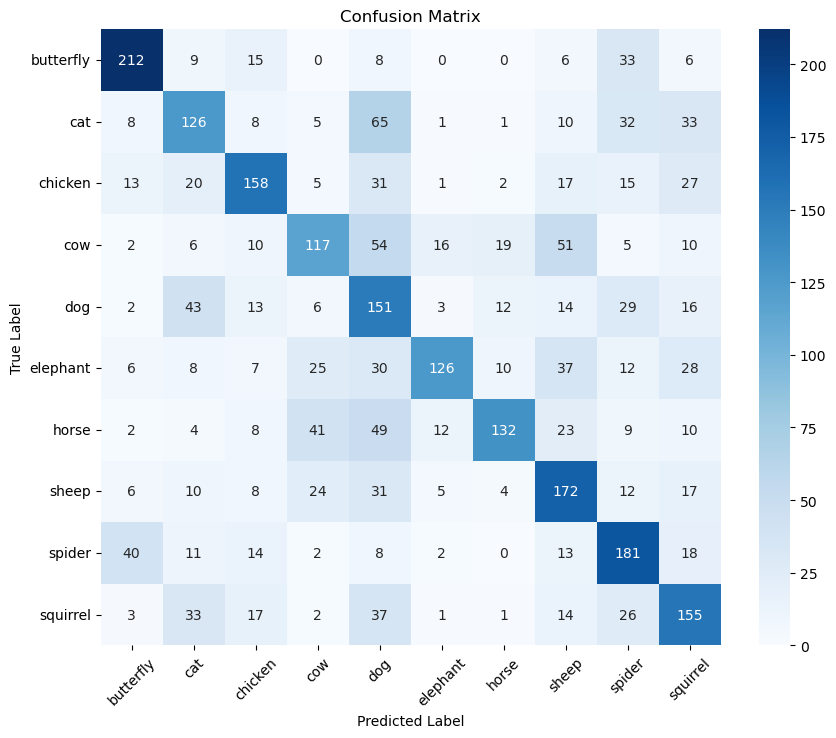

In [12]:
# Predict class probabilities
y_pred_probs = model_01.predict(ds1_X_test)

# Convert probabilities to class predictions
y_pred = y_pred_probs.argmax(axis=1)
y_true = ds1_y_test  # original integer labels

# Compute metrics
model_compare.append({"model": "model_01", 
                      "accuracy_train": history.history['accuracy'][-1], 
                      "loss_train": history.history['loss'][-1], 
                      "val_accuracy_train": history.history['val_accuracy'][-1], 
                      "val_loss_train": history.history['val_loss'][-1], 
                      "accuracy_test": accuracy_score(y_true, y_pred), 
                      "precision_test": precision_score(y_true, y_pred, average='weighted'), 
                      "recall_test":recall_score(y_true, y_pred, average='weighted'), 
                      "f1-score_test":f1_score(y_true, y_pred, average='weighted')})

display(pd.DataFrame(model_compare))

# Labels details
print("\nLabels Details:")
print(classification_report(ds1_y_test, y_pred, target_names=class_names))

# Confusion Matrix
print("\n Confusion Matrix")
plot_confusion_matrix(ds1_y_test, y_pred, class_names)

In [13]:
model_01.save('./output/model_01.keras')
# Free memory before moving forward
#del df_01
del X, y, model_01
del ds1_X_train, ds1_y_train, ds1_y_train_cat, ds1_X_test, ds1_y_test, ds1_y_test_cat
gc.collect()
tf.keras.backend.clear_session()

**Analysis**:
- First model was:
    - Images of 100x100 size and RGB (100, 100, 3)
    - Categories where balanced by taking only the number of images on each category equal to the amount of images in the category with less images
    - 2 convonutional layers (32 and 64 neurons) combined with MaxPoling
    - Convolutional result was Flatten and send as input to a Dense layer activate by ReLU
    - The output layer consist on a 10 neurons layer activated with softmax (multiecategorical problem)
- Training Accuracy was around 0.9 for training set but around 0.5 for test set indicating not only a low capacity of prediction but also a high overfitting.


## Exploratory Data Analysis

### Overall Review:

In [14]:
# Validate all images are unique
print("Are the all the images unique?: ", img_df["hash"].unique().size == img_df.shape[0])

# Review Shape
print("Shape:", img_df.shape)

# Data Types
print("\nData Types")
display(img_df.dtypes)

## Look for NA Values
print("\nNA Values")
display(img_df.isna().sum())

Are the all the images unique?:  True
Shape: (26179, 10)

Data Types


img            object
hash           object
width           int64
height          int64
mode           object
format         object
palette        object
orientation    object
path           object
label          object
dtype: object


NA Values


img                0
hash               0
width              0
height             0
mode               0
format             0
palette        26179
orientation        0
path               0
label              0
dtype: int64

In [15]:
# Split categorical and numerical values
num = img_df.select_dtypes(include="number")
cat = img_df.select_dtypes(exclude="number")

display(cat)
display(num)

,img,hash,mode,format,palette,orientation,path,label
0,OIP-Gpa-3M-3IyJoYATOst0QHgHaHa.jpeg,bf7cb056645f0031e69a52aedd0d0480c286a26b,RGB,JPEG,None,squared,./dataset/raw-img/farfalla/OIP-Gpa-3M-3IyJoYAT...,butterfly
1,e832b70c2af0043ed1584d05fb1d4e9fe777ead218ac10...,3e9dad45c26c3deb96ffea72f12d2128c77050aa,RGB,JPEG,None,squared,./dataset/raw-img/farfalla/e832b70c2af0043ed15...,butterfly
2,ea36b20d2bf6083ed1584d05fb1d4e9fe777ead218ac10...,3a3ef400ebae7605cc0dcb3ebc840cad0463066b,RGB,JPEG,None,landscape,./dataset/raw-img/farfalla/ea36b20d2bf6083ed15...,butterfly
3,OIP-OYm86z-SuQPW_v8_fnzJYQHaFH.jpeg,758e7961d853872f5cfd7fb045b68f083b94f328,RGB,JPEG,None,landscape,./dataset/raw-img/farfalla/OIP-OYm86z-SuQPW_v8...,butterfly
4,OIP-sB8f5rvtA8Rvais3C20drwHaE7.jpeg,41df709171bf1bc36f1df0b8af10cbe77205d5a8,RGB,JPEG,None,landscape,./dataset/raw-img/farfalla/OIP-sB8f5rvtA8Rvais...,butterfly
...,...,...,...,...,...,...,...,...
26174,OIP-8V8StkVgXPGi18csjmEjegHaFh.jpeg,6292e559c0b76293ebaa5aee1ce01c4cd12759df,RGB,JPEG,None,landscape,./dataset/raw-img/elefante/OIP-8V8StkVgXPGi18c...,elephant
26175,OIP-0XAbxzMOUSY1EF0JR5UI4gHaE4.jpeg,f0c93d60976a61697fb5e00ddb3225d608440609,RGB,JPEG,None,landscape,./dataset/raw-img/elefante/OIP-0XAbxzMOUSY1EF0...,elephant
26176,OIP-V8MYzpyMKhYC9KgXO6YmKgHaG-.jpeg,b1595586aac367b720e22a8c1059541f582ee318,RGB,JPEG,None,landscape,./dataset/raw-img/elefante/OIP-V8MYzpyMKhYC9Kg...,elephant
26177,OIP-SrbEBzRGqYXhOo1FYeoyRQHaFr.jpeg,47f8c3b727f8781aea47be2d0e301ba2eb0d7cf3,RGB,JPEG,None,landscape,./dataset/raw-img/elefante/OIP-SrbEBzRGqYXhOo1...,elephant


,width,height
0,300,300
1,640,640
2,640,480
3,300,207
4,300,200
...,...,...
26174,300,224
26175,300,198
26176,300,283
26177,300,230


**Analysis**:
- Palet image property is not helpull since any image have it set
- Mode and Format seems to have all the same value. I'll validate that and discard them if true since it would not provide help.
- Hash column can be removed since it was created to identify duplicated images. It not needed anymore.
- I'll focus on orientation and size and how they relate to label in order to find how to balance better the dataset
- Label was analyzed previously so I'll avoid it here

### Univariate & Bivariate Analysis

##### Mode

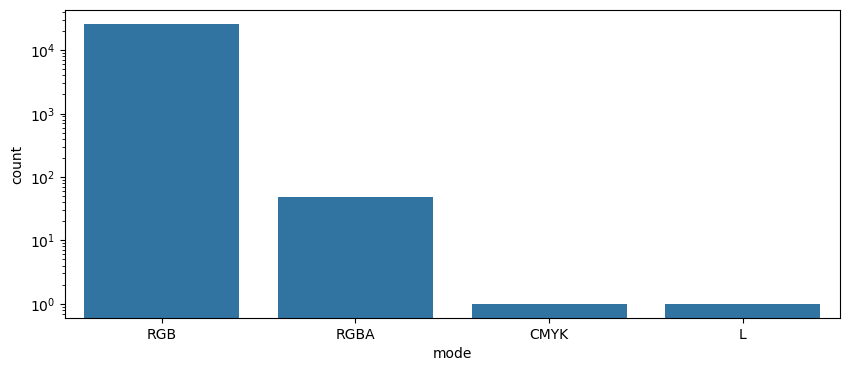

,count,proportion
mode,,
RGB,26128,1.0
RGBA,49,0.0
CMYK,1,0.0
L,1,0.0


In [16]:
cat_analisis(img_df, "mode", log=True, top=False, bottom=False, chart_size=(10,4))

label,butterfly,cat,chicken,cow,dog,elephant,horse,sheep,spider,squirrel
mode,,,,,,,,,,
CMYK,0,0,0,0,0,1,0,0,0,0
L,0,0,0,0,0,1,0,0,0,0
RGB,2073,1667,3098,1866,4863,1436,2623,1820,4820,1862
RGBA,39,1,0,0,0,8,0,0,1,0


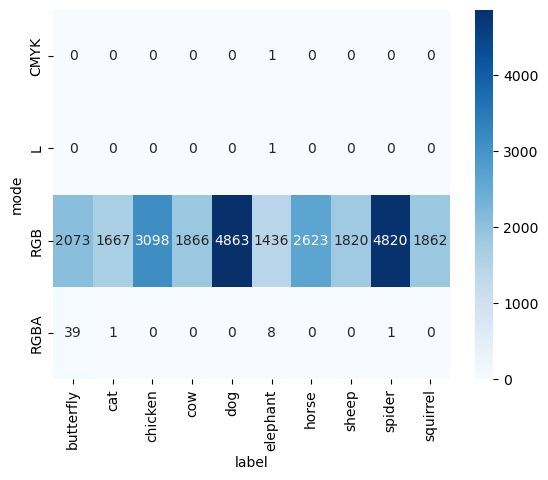

In [17]:
crosstab_result = pd.crosstab(img_df["mode"] , img_df["label"])
display(crosstab_result)

## Stacked / Grouped Bar Charts
sns.heatmap(crosstab_result, annot=True, cmap="Blues", fmt="d")
plt.show();

**Analysis**:
- There are 51 images with different mode than RGB.
- I checked how these 51 lines relate with labels and I see 10 of them are on elephant (the label with less element)

##### Format

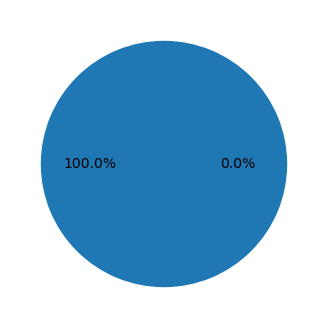

,count,proportion
format,,
JPEG,26128,1.0
PNG,51,0.0


In [18]:
cat_analisis(img_df, "format", log=False, top=False, bottom=False, chart_size=(10,4))

mode,CMYK,L,RGB,RGBA
format,,,,
JPEG,1,1,26126,0
PNG,0,0,2,49


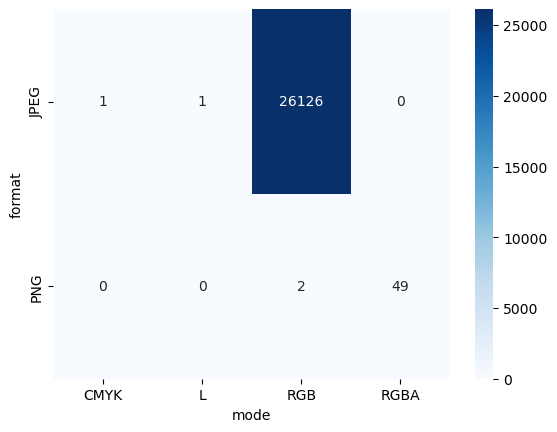

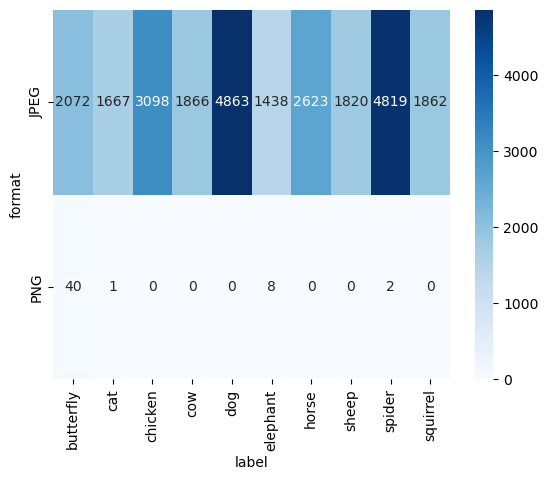

In [19]:
crosstab_result = pd.crosstab(img_df["format"] , img_df["mode"])
display(pd.crosstab(img_df["format"] , img_df["mode"]))
sns.heatmap(crosstab_result, annot=True, cmap="Blues", fmt="d")
plt.show();


crosstab_result = pd.crosstab(img_df["format"] , img_df["label"])
sns.heatmap(crosstab_result, annot=True, cmap="Blues", fmt="d")
plt.show();

**Analysis**:
- There are 51 images with PNG format instead of JPEG. 
- I checked if these 51 are the same that has different mode and are all, except for two
- I also checked how these relate to label and as expected are related to the same labels.

#### Orientation

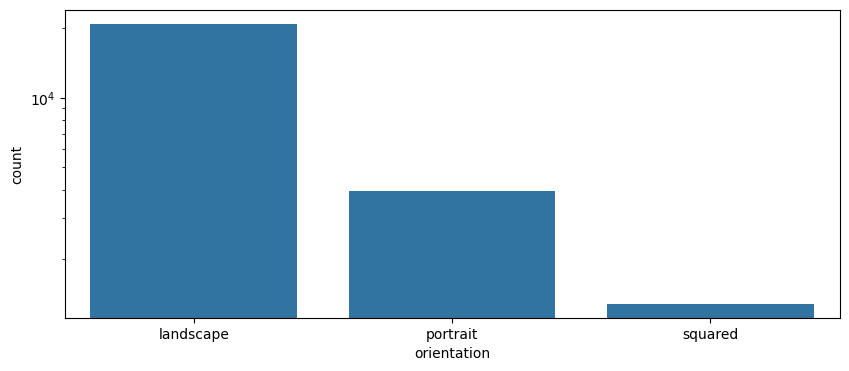

,count,proportion
orientation,,
landscape,20957,0.80
portrait,3943,0.15
squared,1279,0.05


In [20]:
cat_analisis(img_df, "orientation", log=True, top=False, bottom=False, chart_size=(10,4))

label,butterfly,cat,chicken,cow,dog,elephant,horse,sheep,spider,squirrel
orientation,,,,,,,,,,
landscape,1728,1313,2309,1713,3359,1280,2145,1639,3933,1538
portrait,237,252,570,114,1118,128,396,144,712,272
squared,147,103,219,39,386,38,82,37,176,52


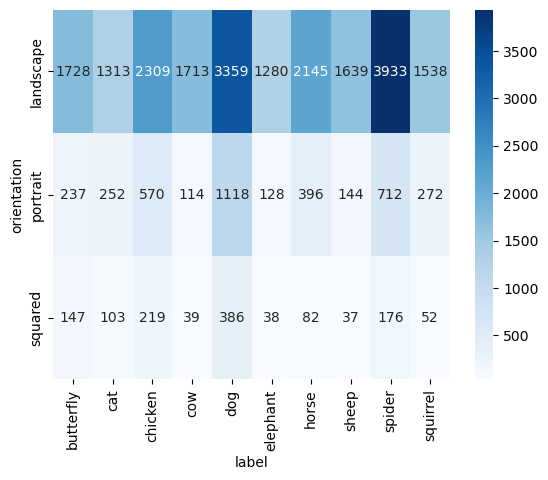

In [21]:
crosstab_result = pd.crosstab(img_df["orientation"] , img_df["label"])
display(crosstab_result)

sns.heatmap(crosstab_result, annot=True, cmap="Blues", fmt="d")
plt.show();

**Analysis**
- 80% of the pictures are in landscape I am not sure if I could standarize the size based on that
- Comparing it with labels I see I could only keep landscape images as a way of balance the dataset

#### Width & Height

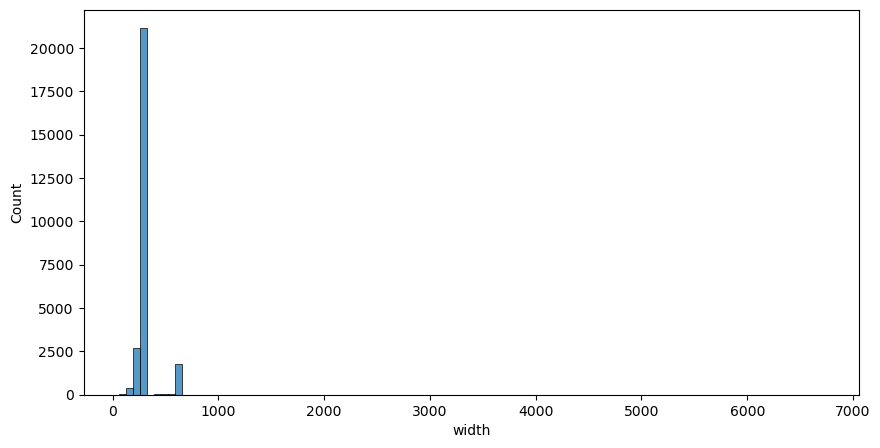

,count,unique,mean,min,quant_25,quant_50,quant_75,max,mode,var,std,skew,kurt
width,26179,283,320.03881,60,300.0,300.0,300.0,6720,300,38783.522598,196.935326,18.421237,439.662233


In [22]:
plt.figure(figsize=(10,5))
plot = sns.histplot(num["width"], bins=100)
#plot.set(yscale='log')
plt.show();

features_desc = describe_complete(num)
features_desc.loc[features_desc.index == "width"]

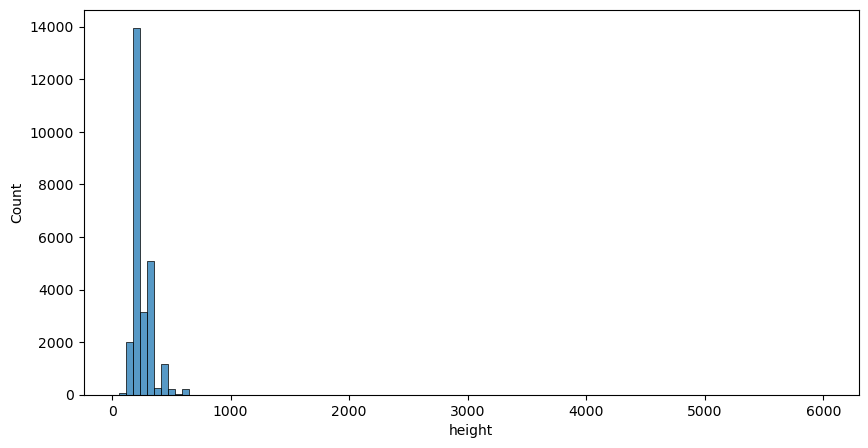

,count,unique,mean,min,quant_25,quant_50,quant_75,max,mode,var,std,skew,kurt
height,26179,454,252.630162,57,200.0,225.0,300.0,6000,300,22023.538743,148.403298,18.387842,470.69987


In [23]:
plt.figure(figsize=(10,5))
plot = sns.histplot(num["height"], bins=100)
#plot.set(yscale='log')
plt.show();

features_desc.loc[features_desc.index == "height"]

**Analysis**:
- I don't think its providing much value to analyze these two variables separated this neither helps to take decisions
- I'll join them and analyze as a categorical value

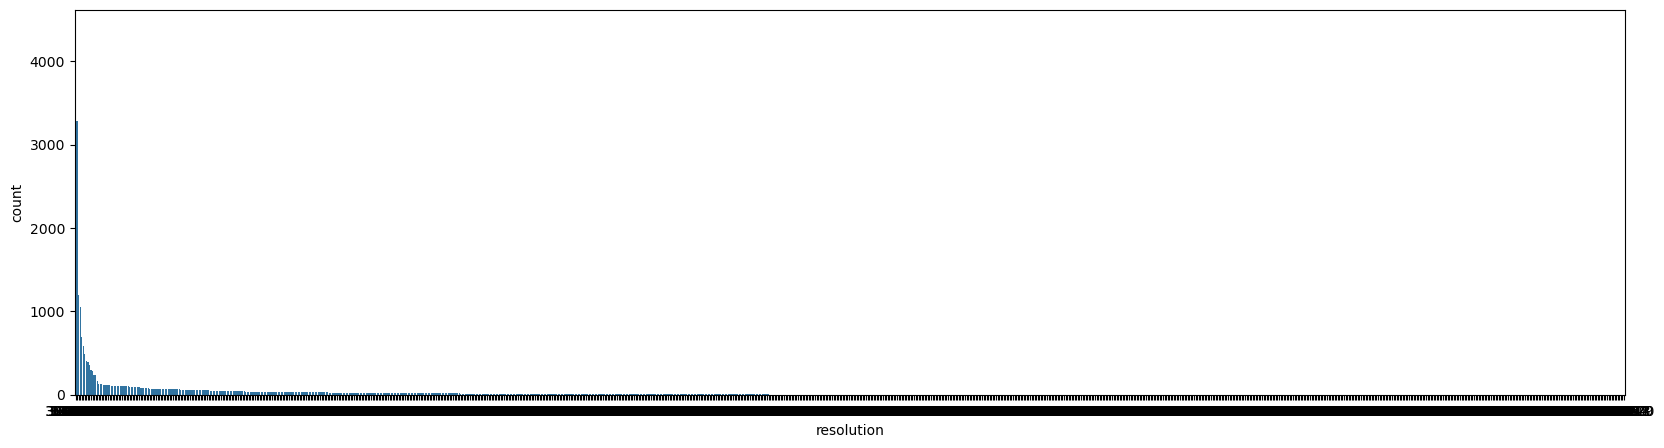

,count,proportion
resolution,,
300x225,4397,0.17
300x200,3281,0.13
300x300,1192,0.05
300x169,1048,0.04
640x426,694,0.03
...,...,...
235x194,1,0.00
640x348,1,0.00
296x211,1,0.00


In [24]:
img_df["resolution"] = img_df.apply(lambda x: str(x["width"]) + "x" + str(x["height"]), axis=1)
cat_analisis(img_df, "resolution", log=False, top=False, bottom=False, chart_size=(20,5))

In [25]:
# How many resolutios are there with more than 0% of images?
freq_table = getFrequencyTable(img_df, "resolution")
display(freq_table[freq_table["proportion"] > 0.00])
print("More than 0%: ", freq_table[freq_table["proportion"] > 0.00]["count"].sum(), " | Less than 0%: ",  freq_table[freq_table["proportion"] <= 0.00]["count"].sum())

,count,proportion
resolution,,
300x225,4397,0.17
300x200,3281,0.13
300x300,1192,0.05
300x169,1048,0.04
640x426,694,0.03
300x199,586,0.02
225x300,490,0.02
300x240,403,0.02
300x188,393,0.02


More than 0%:  14212  | Less than 0%:  11967


In [26]:
# What are the most common distributions in landscale?
freq_table = getFrequencyTable(img_df[img_df["orientation"]=="landscape"], "resolution")
display(freq_table[freq_table["proportion"] > 0.00])
print("More than 0%: ", freq_table[freq_table["proportion"] > 0.00]["count"].sum(), " | Less than 0%: ",  freq_table[freq_table["proportion"] <= 0.00]["count"].sum())

,count,proportion
resolution,,
300x225,4397,0.21
300x200,3281,0.16
300x169,1048,0.05
640x426,694,0.03
300x199,586,0.03
300x240,403,0.02
300x188,393,0.02
300x221,299,0.01
300x201,288,0.01


More than 0%:  13301  | Less than 0%:  7656


**Analysis**
- There are to many sizes to take a conclusion on what to do with them.
- 45% of the sizes have less than 1% of images, the rest of the images share 16 sizes
- 63% of landscape resolutions have at least 1% of images.

## Improving the model

### Model 2

Based on the resultd of the dataset I am going to do a model with the same configuration than previously but changing the dataset
I want to try:
- Keep only the landscape images
- Keep only images in JPEG and RGB
- Split dataset in 3, since I am using test for the early stop I would like to do the final validation with data haven't seen before.

In [27]:
# Prepare Dataset
# TEST 1
#df_02 = balance_labels(img_df[(img_df["orientation"]=="landscape") & (img_df["format"]=="JPEG") & (img_df["mode"]=="RGB")], label_colum="label", seed=seed)
# TEST 2
#df_02 = balance_labels(img_df[(img_df["orientation"]=="landscape")], label_colum="label", seed=seed)
# TEST 3
df_02 = balance_labels(img_df[(img_df["format"]=="JPEG") & (img_df["mode"]=="RGB")], label_colum="label", shuffle=True, seed=seed)
df_02

,img,hash,width,height,mode,format,palette,orientation,path,label,resolution
0,OIP-Gpa-3M-3IyJoYATOst0QHgHaHa.jpeg,bf7cb056645f0031e69a52aedd0d0480c286a26b,300,300,RGB,JPEG,None,squared,./dataset/raw-img/farfalla/OIP-Gpa-3M-3IyJoYAT...,butterfly,300x300
2,ea36b20d2bf6083ed1584d05fb1d4e9fe777ead218ac10...,3a3ef400ebae7605cc0dcb3ebc840cad0463066b,640,480,RGB,JPEG,None,landscape,./dataset/raw-img/farfalla/ea36b20d2bf6083ed15...,butterfly,640x480
3,OIP-OYm86z-SuQPW_v8_fnzJYQHaFH.jpeg,758e7961d853872f5cfd7fb045b68f083b94f328,300,207,RGB,JPEG,None,landscape,./dataset/raw-img/farfalla/OIP-OYm86z-SuQPW_v8...,butterfly,300x207
5,ea34b70a20fd083ed1584d05fb1d4e9fe777ead218ac10...,9cc14a83b9c5f1abb5bbcf7f3b6df496801e12f8,640,426,RGB,JPEG,None,landscape,./dataset/raw-img/farfalla/ea34b70a20fd083ed15...,butterfly,640x426
6,ea36b30628f0053ed1584d05fb1d4e9fe777ead218ac10...,4b817a3f6cb74089d04203c49b43ae2d3a575662,640,426,RGB,JPEG,None,landscape,./dataset/raw-img/farfalla/ea36b30628f0053ed15...,butterfly,640x426
...,...,...,...,...,...,...,...,...,...,...,...
26174,OIP-8V8StkVgXPGi18csjmEjegHaFh.jpeg,6292e559c0b76293ebaa5aee1ce01c4cd12759df,300,224,RGB,JPEG,None,landscape,./dataset/raw-img/elefante/OIP-8V8StkVgXPGi18c...,elephant,300x224
26175,OIP-0XAbxzMOUSY1EF0JR5UI4gHaE4.jpeg,f0c93d60976a61697fb5e00ddb3225d608440609,300,198,RGB,JPEG,None,landscape,./dataset/raw-img/elefante/OIP-0XAbxzMOUSY1EF0...,elephant,300x198
26176,OIP-V8MYzpyMKhYC9KgXO6YmKgHaG-.jpeg,b1595586aac367b720e22a8c1059541f582ee318,300,283,RGB,JPEG,None,landscape,./dataset/raw-img/elefante/OIP-V8MYzpyMKhYC9Kg...,elephant,300x283
26177,OIP-SrbEBzRGqYXhOo1FYeoyRQHaFr.jpeg,47f8c3b727f8781aea47be2d0e301ba2eb0d7cf3,300,230,RGB,JPEG,None,landscape,./dataset/raw-img/elefante/OIP-SrbEBzRGqYXhOo1...,elephant,300x230


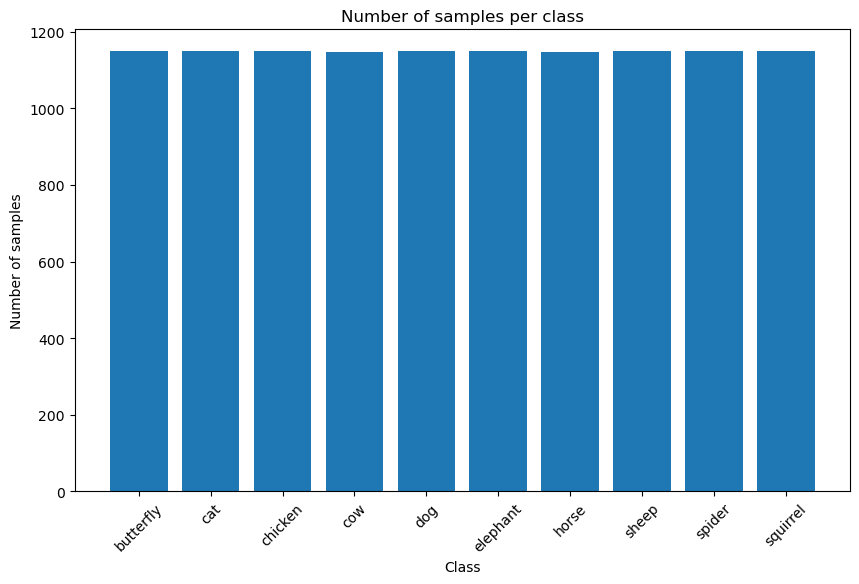

Training data shape X:  (11488, 100, 100, 3) , y: (11488, 10)
Test data shape X:  (2872, 100, 100, 3) , y: (2872, 10)


In [28]:
### 1. Data Preprocessing
ds2_X, ds2_y, ds2_y_cat, ds2_class_names = preprocess_data(df_02, path_column = "path", label_column = "label", img_width = img_width, img_height = img_height, seed = seed)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,333,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,354,378 (16.61 MB)

 Trainable params: 4,354,378 (16.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2434 - loss: 2.0595

W0000 00:00:1750055983.665940     495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750055983.666968     495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750055983.667930     495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2439 - loss: 2.0584 - val_accuracy: 0.4617 - val_loss: 1.5482
Epoch 2/60
 18/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4774 - loss: 1.5009

W0000 00:00:1750055983.971339     500 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750055983.972803     500 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5082 - loss: 1.4402 - val_accuracy: 0.5219 - val_loss: 1.4145
Epoch 3/60
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6198 - loss: 1.1320 - val_accuracy: 0.5052 - val_loss: 1.5464
Epoch 4/60
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7188 - loss: 0.8627 - val_accuracy: 0.5084 - val_loss: 1.6828
Epoch 5/60
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7926 - loss: 0.6513 - val_accuracy: 0.4986 - val_loss: 1.8811
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


W0000 00:00:1750055989.236222     496 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750055989.237372     496 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


,model,accuracy_train,loss_train,val_accuracy_train,val_loss_train,accuracy_test,precision_test,recall_test,f1-score_test
0,model_01,0.830999,0.521517,0.501729,1.815209,0.529046,0.560268,0.529046,0.532693
1,model_02,0.806146,0.611757,0.498607,1.881110,0.521936,0.542052,0.521936,0.520516



Labels Details:
              precision    recall  f1-score   support

   butterfly       0.76      0.72      0.74       287
         cat       0.52      0.35      0.42       287
     chicken       0.45      0.63      0.52       287
         cow       0.63      0.40      0.49       288
         dog       0.41      0.35      0.38       287
    elephant       0.54      0.59      0.56       287
       horse       0.63      0.44      0.52       288
       sheep       0.56      0.51      0.53       287
      spider       0.55      0.61      0.58       287
    squirrel       0.37      0.63      0.47       287

    accuracy                           0.52      2872
   macro avg       0.54      0.52      0.52      2872
weighted avg       0.54      0.52      0.52      2872


 Confusion Matrix


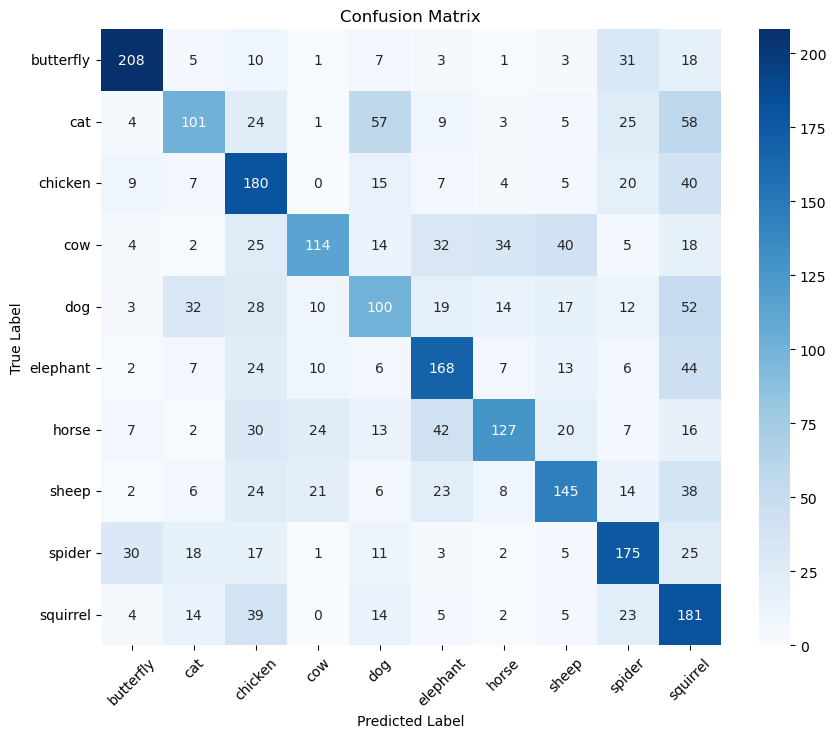

In [29]:
### 2. Model Architecture
model_02 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(ds2_class_names), activation='softmax')
])
model_02.summary()

# Complie Model
model_02.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stop
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=3, restore_best_weights=True )

### 3. Model Training
# Train the model with early stopping
history = model_02.fit(ds2_X["train"], ds2_y_cat["train"], epochs=60, batch_size=64, validation_data=(ds2_X["test"], ds2_y_cat["test"]), callbacks=[early_stopping])

# Predict class probabilities
y_pred_probs = model_02.predict(ds2_X["test"])

# Convert probabilities to class predictions
y_pred = y_pred_probs.argmax(axis=1)
y_true = ds2_y["test"] # original integer labels

### 4. Model Evaluation
# Compute metrics
model_compare.append({"model": "model_02", 
                      "accuracy_train": history.history['accuracy'][-1], 
                      "loss_train": history.history['loss'][-1], 
                      "val_accuracy_train": history.history['val_accuracy'][-1], 
                      "val_loss_train": history.history['val_loss'][-1], 
                      "accuracy_test": accuracy_score(y_true, y_pred), 
                      "precision_test": precision_score(y_true, y_pred, average='weighted'), 
                      "recall_test":recall_score(y_true, y_pred, average='weighted'), 
                      "f1-score_test":f1_score(y_true, y_pred, average='weighted')})

display(pd.DataFrame(model_compare))

# Labels details
print("\nLabels Details:")
print(classification_report(y_true, y_pred, target_names=ds2_class_names))

# Confusion Matrix
print("\n Confusion Matrix")
plot_confusion_matrix(y_true, y_pred, ds2_class_names)


**Analysis**
- After some tests I found removing the non-landscape images makes the model worst.
- Keeping only the JPEG and RGB slightly improves the model.

In [30]:
model_02.save('./output/model_02.keras')
# Free memory before moving forward
del model_02
gc.collect()
tf.keras.backend.clear_session()

### Model 3

After reviewing the results of the model 2, I am going to continue using the dataset 2 but I'll try to improve predictions through data augmentation.

In [31]:
# Data Agumentation
ds2_augmentation_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.30,
    zoom_range=0.95,
    horizontal_flip=True,
    fill_mode='nearest'
)

ds2_train_data = ds2_augmentation_generator.flow(ds2_X["train"], ds2_y_cat["train"], batch_size=32, shuffle=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,333,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,354,378 (16.61 MB)

 Trainable params: 4,354,378 (16.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.1864 - loss: 2.2579 - val_accuracy: 0.3134 - val_loss: 1.9258
Epoch 2/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.3039 - loss: 1.9539 - val_accuracy: 0.3854 - val_loss: 1.7172
Epoch 3/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.3462 - loss: 1.8471 - val_accuracy: 0.4189 - val_loss: 1.6748
Epoch 4/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.3729 - loss: 1.7722 - val_accuracy: 0.3865 - val_loss: 1.8003
Epoch 5/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.3961 - loss: 1.7302 - val_accuracy: 0.4575 - val_loss: 1.5553
Epoch 6/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4055 - loss: 1.6856 - val_accuracy: 0.4150 - val_loss: 1.7745
Epoch 7/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4270 - loss: 1.6463 - val_accuracy: 0.5045 - val_loss: 1.4268
Epoch 8/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.4528 - loss: 1.5978 - 

,model,accuracy_train,loss_train,val_accuracy_train,val_loss_train,accuracy_test,precision_test,recall_test,f1-score_test
0,model_01,0.830999,0.521517,0.501729,1.815209,0.529046,0.560268,0.529046,0.532693
1,model_02,0.806146,0.611757,0.498607,1.881110,0.521936,0.542052,0.521936,0.520516
2,model_03,0.501480,1.431633,0.544916,1.328481,0.564415,0.560131,0.564415,0.553063



Labels Details:
              precision    recall  f1-score   support

   butterfly       0.66      0.85      0.74       287
         cat       0.56      0.31      0.40       287
     chicken       0.55      0.78      0.64       287
         cow       0.50      0.49      0.50       288
         dog       0.51      0.40      0.45       287
    elephant       0.55      0.70      0.62       287
       horse       0.52      0.46      0.49       288
       sheep       0.55      0.44      0.49       287
      spider       0.63      0.68      0.65       287
    squirrel       0.57      0.53      0.55       287

    accuracy                           0.56      2872
   macro avg       0.56      0.56      0.55      2872
weighted avg       0.56      0.56      0.55      2872


 Confusion Matrix


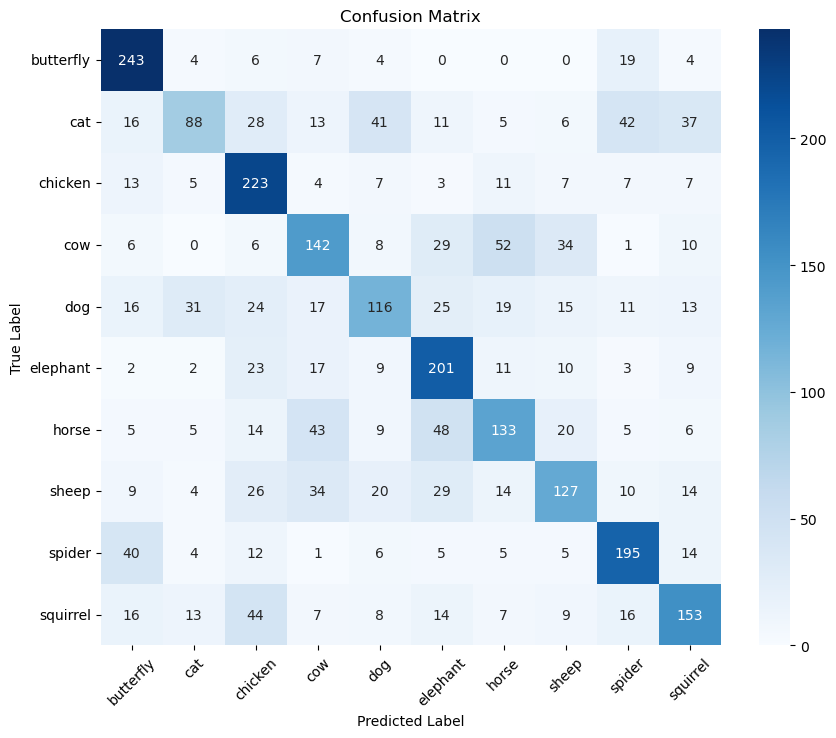

In [32]:
### 2. Model Architecture
model_03 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(ds2_class_names), activation='softmax')
])
model_03.summary()

# Complie Model
model_03.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### 3. Model Training
# Train the model with previous early stopping
history = model_03.fit(ds2_train_data, epochs=60, batch_size=64, validation_data=(ds2_X["test"], ds2_y_cat["test"]), callbacks=[early_stopping])

# Predict class probabilities
y_pred_probs = model_03.predict(ds2_X["test"])

# Convert probabilities to class predictions
y_pred = y_pred_probs.argmax(axis=1)
y_true = ds2_y["test"]  # original integer labels

### 4. Model Evaluation
# Compute metrics
model_compare.append({"model": "model_03", 
                      "accuracy_train": history.history['accuracy'][-1], 
                      "loss_train": history.history['loss'][-1], 
                      "val_accuracy_train": history.history['val_accuracy'][-1], 
                      "val_loss_train": history.history['val_loss'][-1], 
                      "accuracy_test": accuracy_score(y_true, y_pred), 
                      "precision_test": precision_score(y_true, y_pred, average='weighted'), 
                      "recall_test":recall_score(y_true, y_pred, average='weighted'), 
                      "f1-score_test":f1_score(y_true, y_pred, average='weighted')})

display(pd.DataFrame(model_compare))

# Labels details
print("\nLabels Details:")
print(classification_report(y_true, y_pred, target_names=ds2_class_names))

# Confusion Matrix
print("\n Confusion Matrix")
plot_confusion_matrix(y_true, y_pred, ds2_class_names)


In [33]:
model_03.save('./output/model_03.keras')
# Free memory before moving forward
del model_03
gc.collect()
tf.keras.backend.clear_session()

**Analyisis**
- After some tweaking in the parameters of the data generator I achieved I slightly improvement on accuracy
- While the impact on accurany is not high the improvement on overfitting is great (accuracy train - accuracy test went from 0.348 to -0.004)

### Model 4

Result was worst, I am going to keep the dataset and tweak parameters

Epoch 1/60
  7/359 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.1197 - loss: 2.3275

W0000 00:00:1750056164.563200     495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750056164.565520     495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750056164.567226     495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750056164.568076     495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750056164.568969     495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750056164.569791     495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.1388 - loss: 2.2658 - val_accuracy: 0.2016 - val_loss: 2.0445
Epoch 2/60
  1/359 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.1562 - loss: 2.2054

W0000 00:00:1750056174.755058     502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750056174.756722     502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750056174.758513     502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750056174.760177     502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750056174.879388     502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750056174.881217     502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.2651 - loss: 2.0132 - val_accuracy: 0.3677 - val_loss: 1.7561
Epoch 3/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.3291 - loss: 1.8688 - val_accuracy: 0.3865 - val_loss: 1.6977
Epoch 4/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.3719 - loss: 1.7830 - val_accuracy: 0.3896 - val_loss: 1.6960
Epoch 5/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.3876 - loss: 1.7299 - val_accuracy: 0.4335 - val_loss: 1.5850
Epoch 6/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4092 - loss: 1.6644 - val_accuracy: 0.4899 - val_loss: 1.4584
Epoch 7/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4311 - loss: 1.6090 - val_accuracy: 0.5205 - val_loss: 1.3692
Epoch 8/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4701 - loss: 1.5545 - val_accuracy: 0.5515 - val_loss: 1.2994
Epoch 9/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4715 - loss: 1.5145 - val_accurac

W0000 00:00:1750056750.749908     497 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


W0000 00:00:1750056751.031103     497 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


,model,accuracy_train,loss_train,val_accuracy_train,val_loss_train,accuracy_test,precision_test,recall_test,f1-score_test
0,model_01,0.830999,0.521517,0.501729,1.815209,0.529046,0.560268,0.529046,0.532693
1,model_02,0.806146,0.611757,0.498607,1.881110,0.521936,0.542052,0.521936,0.520516
2,model_03,0.501480,1.431633,0.544916,1.328481,0.564415,0.560131,0.564415,0.553063
3,model_04,0.642671,1.019825,0.701253,0.995752,0.702646,0.712956,0.702646,0.699232



Labels Details:
              precision    recall  f1-score   support

   butterfly       0.69      0.92      0.79       287
         cat       0.72      0.57      0.64       287
     chicken       0.80      0.82      0.81       287
         cow       0.74      0.57      0.64       288
         dog       0.69      0.55      0.61       287
    elephant       0.70      0.84      0.76       287
       horse       0.58      0.77      0.66       288
       sheep       0.70      0.64      0.67       287
      spider       0.86      0.63      0.73       287
    squirrel       0.65      0.71      0.68       287

    accuracy                           0.70      2872
   macro avg       0.71      0.70      0.70      2872
weighted avg       0.71      0.70      0.70      2872


 Confusion Matrix


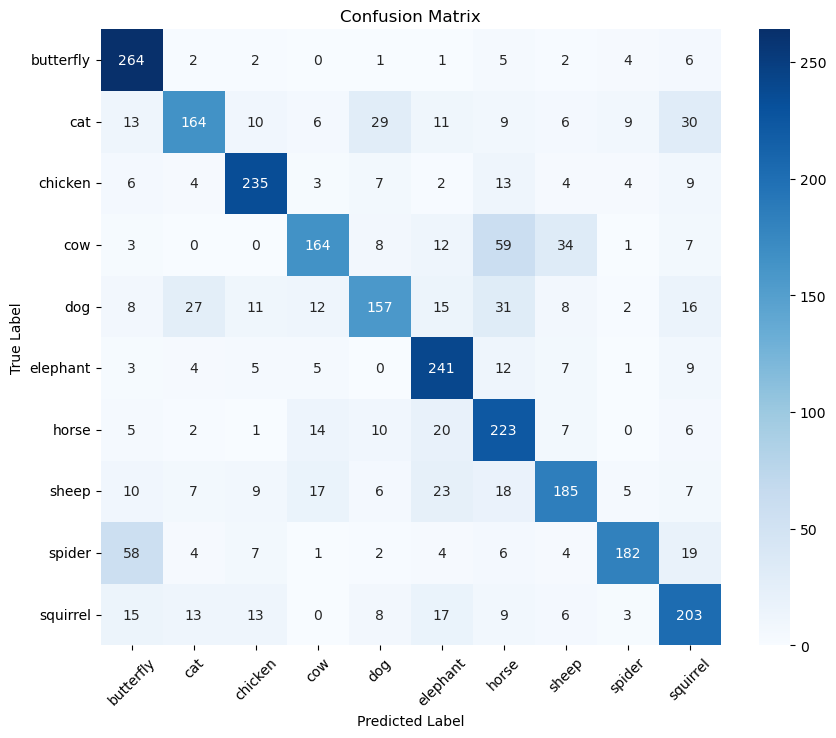

In [34]:
### 2. Model Architecture
model_04 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(ds2_class_names), activation='softmax')
])

# Complie Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_04.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Data Augmentation
ds2_train_data = ds2_augmentation_generator.flow(ds2_X["train"], ds2_y_cat["train"], batch_size=32, shuffle=True)

# Early Stop
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True )

### 3. Model Training
# Train the model with early stopping
history = model_04.fit(ds2_train_data, 
                       epochs=60, batch_size=128,
                       validation_data=(ds2_X["test"], ds2_y_cat["test"]), callbacks=[early_stopping])

# Predict class probabilities
y_pred_probs = model_04.predict(ds2_X["test"])

# Convert probabilities to class predictions
y_pred = y_pred_probs.argmax(axis=1)
y_true = ds2_y["test"]  # original integer labels

### 4. Model Evaluation
# Compute metrics
model_compare.append({"model": "model_04", 
                      "accuracy_train": history.history['accuracy'][-1], 
                      "loss_train": history.history['loss'][-1], 
                      "val_accuracy_train": history.history['val_accuracy'][-1], 
                      "val_loss_train": history.history['val_loss'][-1], 
                      "accuracy_test": accuracy_score(y_true, y_pred), 
                      "precision_test": precision_score(y_true, y_pred, average='weighted'), 
                      "recall_test":recall_score(y_true, y_pred, average='weighted'), 
                      "f1-score_test":f1_score(y_true, y_pred, average='weighted')})

display(pd.DataFrame(model_compare))

# Labels details
print("\nLabels Details:")
print(classification_report(y_true, y_pred, target_names=ds2_class_names))

# Confusion Matrix
print("\n Confusion Matrix")
plot_confusion_matrix(y_true, y_pred, ds2_class_names)

**Analysis**:

- By changing the model architecture (added 2 convonutional layers of 128 and 156) and changing some settings (epoch and batch_size) the accuracy in the model increased until 0.659

In [35]:
model_04.save('./output/model_04.keras')
# Free memory before moving forward
del model_04
del optimizer, ds2_augmentation_generator, ds2_train_data, early_stopping
del ds2_X, ds2_y, ds2_y_cat, ds2_class_names
gc.collect()
tf.keras.backend.clear_session()

## 5. Transfer Learning

- Perform transfer learning with your chosen pre-trained models i.e., you will probably try a few and choose the best one (e.g., VGG16, Inception, ResNet trained on ImageNet)

- Train and evaluate the transfer learning model.

- Compare its performance against your custom CNN.

- Discuss advantages and trade-offs of using transfer learning over building a model from scratch.


#### MobileNetV2

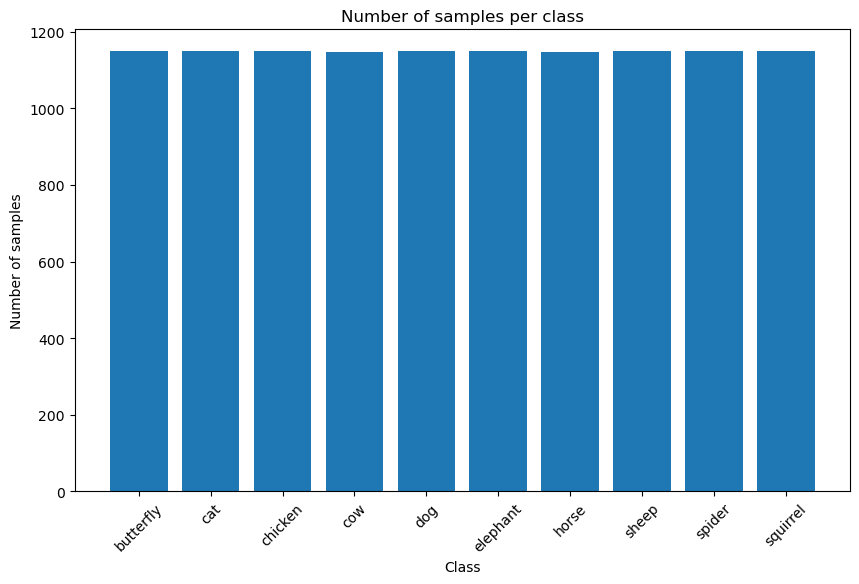

Training data shape X:  (11488, 96, 96, 3) , y: (11488, 10)
Test data shape X:  (2872, 96, 96, 3) , y: (2872, 10)


In [36]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mnv2_preprocess_input

img_height = 96
img_width  = 96

# preprocess features
mnv2_X, mnv2_y, mnv2_y_cat, mnv2_class_names = preprocess_data(df_02, path_column = "path", label_column = "label", img_width = img_width, img_height = img_height, normalizer=mnv2_preprocess_input, seed = seed)

Epoch 1/10


W0000 00:00:1750056767.678201     503 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8416 - loss: 0.5082 - val_accuracy: 0.9311 - val_loss: 0.2174
Epoch 2/10
 31/359 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9630 - loss: 0.1220

W0000 00:00:1750056770.041107     493 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9596 - loss: 0.1277 - val_accuracy: 0.9286 - val_loss: 0.2434
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9820 - loss: 0.0592 - val_accuracy: 0.9342 - val_loss: 0.2460
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9922 - loss: 0.0303 - val_accuracy: 0.9349 - val_loss: 0.2770
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9937 - loss: 0.0224 - val_accuracy: 0.9338 - val_loss: 0.2872
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9957 - loss: 0.0172 - val_accuracy: 0.9248 - val_loss: 0.3584
Epoch 7/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9951 - loss: 0.0151 - val_accuracy: 0.9314 - val_loss: 0.3288
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9964 - loss: 0.0120 - val_accuracy: 0.9318 - val_loss: 0.3737
Epoch 9/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9958 - loss: 0.0118 - val_accuracy: 0.9272 - val_

,model,accuracy_train,loss_train,val_accuracy_train,val_loss_train,accuracy_test,precision_test,recall_test,f1-score_test
0,model_01,0.830999,0.521517,0.501729,1.815209,0.529046,0.560268,0.529046,0.532693
1,model_02,0.806146,0.611757,0.498607,1.881110,0.521936,0.542052,0.521936,0.520516
2,model_03,0.501480,1.431633,0.544916,1.328481,0.564415,0.560131,0.564415,0.553063
3,model_04,0.642671,1.019825,0.701253,0.995752,0.702646,0.712956,0.702646,0.699232
4,mnv2_model,0.989815,0.032202,0.926880,0.416603,0.931058,0.932087,0.931058,0.931222



Labels Details:
              precision    recall  f1-score   support

   butterfly       0.96      0.97      0.97       287
         cat       0.99      0.92      0.95       287
     chicken       0.98      0.96      0.97       287
         cow       0.85      0.89      0.87       288
         dog       0.91      0.92      0.92       287
    elephant       0.96      0.91      0.93       287
       horse       0.92      0.89      0.90       288
       sheep       0.89      0.90      0.90       287
      spider       0.96      0.98      0.97       287
    squirrel       0.91      0.97      0.94       287

    accuracy                           0.93      2872
   macro avg       0.93      0.93      0.93      2872
weighted avg       0.93      0.93      0.93      2872


 Confusion Matrix


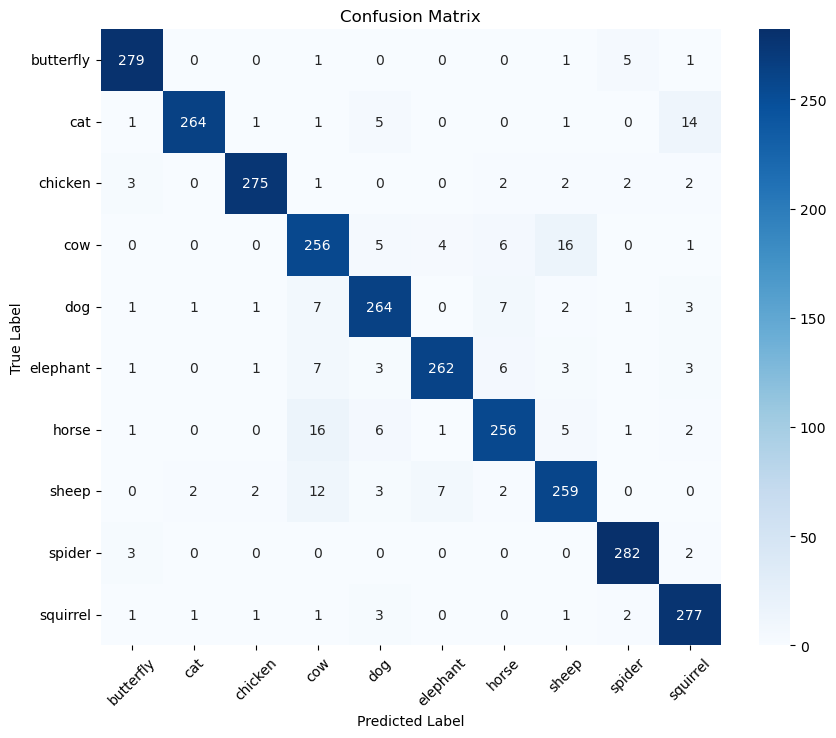

In [37]:
# Load pre-trained model
mnv2_base = MobileNetV2(input_shape=(img_height, img_width, 3), alpha=1, include_top=False, weights='imagenet', classes=len(mnv2_class_names))
mnv2_base.trainable = False  # Freeze base

# Create custom classifier
mnv2_model = tf.keras.models.Sequential([
    mnv2_base,
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(mnv2_class_names), activation='softmax')
])

# Compile the model
mnv2_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
mnv2_model.compile(optimizer=mnv2_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stop
mnv2_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True,  start_from_epoch=0)

# Train the model
history = mnv2_model.fit(mnv2_X["train"], mnv2_y_cat["train"],
                        epochs=10, batch_size=32,  
                        validation_data=(mnv2_X["test"], mnv2_y_cat["test"]), callbacks=[mnv2_early_stopping])

# Evaluate the model
y_pred_probs = mnv2_model.predict(mnv2_X["test"])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = mnv2_y["test"]  # original integer labels

# Overal Model Metrics
# Compute metrics
model_compare.append({"model": "mnv2_model", 
                      "accuracy_train": history.history['accuracy'][-1], 
                      "loss_train": history.history['loss'][-1], 
                      "val_accuracy_train": history.history['val_accuracy'][-1], 
                      "val_loss_train": history.history['val_loss'][-1], 
                      "accuracy_test": accuracy_score(y_true, y_pred), 
                      "precision_test": precision_score(y_true, y_pred, average='weighted'), 
                      "recall_test":recall_score(y_true, y_pred, average='weighted'), 
                      "f1-score_test":f1_score(y_true, y_pred, average='weighted')})

display(pd.DataFrame(model_compare))

# Metrics per label
print("\nLabels Details:")
print(classification_report(y_true, y_pred, target_names=mnv2_class_names))

# Confusion matrix
print("\n Confusion Matrix")
plot_confusion_matrix(y_true, y_pred, mnv2_class_names)

**Analysis**:
- The model using MobileNetV2 as base model with just 3 more layers improve the accuracy of the model until 0.93 also reduced the fitting time from minutes to seconds

##### Fine-Tunning

In [38]:
# Unfreeze last layers of base model for fine-tuning
mnv2_model.trainable = True

# Freeze all layers except the last 50 layers
fine_tune_at = len(mnv2_model.layers) - 50
for layer in mnv2_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile model with a lower learning rate
mnv2_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training (fine-tuning)
fine_tune_epochs = 10

history = mnv2_model.fit(
    mnv2_X["train"], mnv2_y_cat["train"],
    validation_split=0.2,
    epochs= 3 + fine_tune_epochs, # if trained earlier 3 epochs + fine_tune_epochs
    initial_epoch=3,
    batch_size=64
)

# Evaluate the model
y_pred_probs = mnv2_model.predict(mnv2_X["test"])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = mnv2_y["test"]  # original integer labels

model_compare.append({"model": "mnv2_model (fine tune)", 
                      "accuracy_train": history.history['accuracy'][-1], 
                      "loss_train": history.history['loss'][-1], 
                      "val_accuracy_train": history.history['val_accuracy'][-1], 
                      "val_loss_train": history.history['val_loss'][-1], 
                      "accuracy_test": accuracy_score(y_true, y_pred), 
                      "precision_test": precision_score(y_true, y_pred, average='weighted'), 
                      "recall_test":recall_score(y_true, y_pred, average='weighted'), 
                      "f1-score_test":f1_score(y_true, y_pred, average='weighted')})

display(pd.DataFrame(model_compare))

Epoch 4/13
 20/144 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9761 - loss: 0.0876

W0000 00:00:1750056787.730800     503 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


141/144 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9697 - loss: 0.1025

W0000 00:00:1750056788.596309     500 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9696 - loss: 0.1026 - val_accuracy: 0.9674 - val_loss: 0.1121
Epoch 5/13
 30/144 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9736 - loss: 0.0926

W0000 00:00:1750056789.364712     501 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9696 - loss: 0.1010 - val_accuracy: 0.9678 - val_loss: 0.1109
Epoch 6/13
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9703 - loss: 0.0997 - val_accuracy: 0.9691 - val_loss: 0.1100
Epoch 7/13
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9710 - loss: 0.0985 - val_accuracy: 0.9687 - val_loss: 0.1092
Epoch 8/13
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9717 - loss: 0.0975 - val_accuracy: 0.9695 - val_loss: 0.1085
Epoch 9/13
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9719 - loss: 0.0966 - val_accuracy: 0.9695 - val_loss: 0.1079
Epoch 10/13
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9718 - loss: 0.0958 - val_accuracy: 0.9691 - val_loss: 0.1074
Epoch 11/13
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9726 - loss: 0.0951 - val_accuracy: 0.9695 - val_loss: 0.1069
Epoch 12/13
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9731 - loss: 0.0944 - val_accuracy: 0.9704 - v

,model,accuracy_train,loss_train,val_accuracy_train,val_loss_train,accuracy_test,precision_test,recall_test,f1-score_test
0,model_01,0.830999,0.521517,0.501729,1.815209,0.529046,0.560268,0.529046,0.532693
1,model_02,0.806146,0.611757,0.498607,1.881110,0.521936,0.542052,0.521936,0.520516
2,model_03,0.501480,1.431633,0.544916,1.328481,0.564415,0.560131,0.564415,0.553063
3,model_04,0.642671,1.019825,0.701253,0.995752,0.702646,0.712956,0.702646,0.699232
4,mnv2_model,0.989815,0.032202,0.926880,0.416603,0.931058,0.932087,0.931058,0.931222
5,mnv2_model (fine tune),0.971382,0.094761,0.970409,0.106102,0.936630,0.936988,0.936630,0.936687


In [39]:
mnv2_model.save('./output/mnv2_model.keras')
# Free memory before moving forward
del mnv2_model, mnv2_base, mnv2_optimizer
del mnv2_X, mnv2_y, mnv2_y_cat, mnv2_class_names, mnv2_early_stopping
gc.collect()
tf.keras.backend.clear_session()

#### EfficientNetV2B3

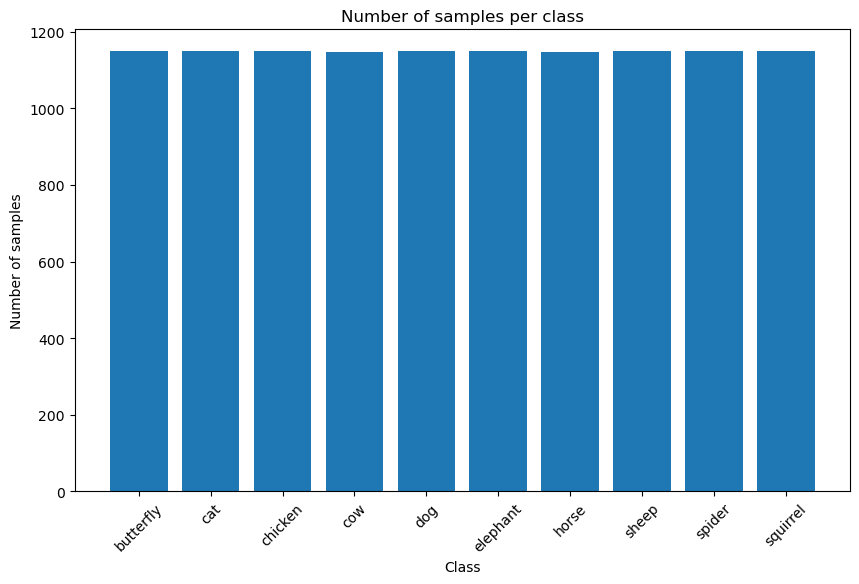

Training data shape X:  (11488, 96, 96, 3) , y: (11488, 10)
Test data shape X:  (2872, 96, 96, 3) , y: (2872, 10)


In [40]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3

img_height = 96
img_width  = 96

# preprocess features
enb3_X, enb3_y, enb3_y_cat, enb3_class_names = preprocess_data(df_02, path_column = "path", label_column = "label", img_width = img_width, img_height = img_height, seed = seed) # , normalizer=enb3_preprocess_input

Epoch 1/100
16/77 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3714 - loss: 1.9497

W0000 00:00:1750056831.022683     501 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


75/77 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6735 - loss: 1.0335

W0000 00:00:1750056831.929247     493 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6791 - loss: 1.0156 - val_accuracy: 0.9088 - val_loss: 0.2847
Epoch 2/100
11/77 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9240 - loss: 0.2235

W0000 00:00:1750056832.713320     495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9243 - loss: 0.2299 - val_accuracy: 0.9154 - val_loss: 0.2679
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9529 - loss: 0.1515 - val_accuracy: 0.9150 - val_loss: 0.2739
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9714 - loss: 0.1053 - val_accuracy: 0.9154 - val_loss: 0.2829
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9830 - loss: 0.0768 - val_accuracy: 0.9164 - val_loss: 0.2875
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9911 - loss: 0.0576 - val_accuracy: 0.9147 - val_loss: 0.2912
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9919 - loss: 0.0455 - val_accuracy: 0.9150 - val_loss: 0.2953
Epoch 8/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9942 - loss: 0.0380 - val_accuracy: 0.9133 - val_loss: 0.3140
Epoch 9/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9957 - loss: 0.0336 - val_accuracy: 0.9161 - val_l

,model,accuracy_train,loss_train,val_accuracy_train,val_loss_train,accuracy_test,precision_test,recall_test,f1-score_test
0,model_01,0.830999,0.521517,0.501729,1.815209,0.529046,0.560268,0.529046,0.532693
1,model_02,0.806146,0.611757,0.498607,1.881110,0.521936,0.542052,0.521936,0.520516
2,model_03,0.501480,1.431633,0.544916,1.328481,0.564415,0.560131,0.564415,0.553063
3,model_04,0.642671,1.019825,0.701253,0.995752,0.702646,0.712956,0.702646,0.699232
4,mnv2_model,0.989815,0.032202,0.926880,0.416603,0.931058,0.932087,0.931058,0.931222
5,mnv2_model (fine tune),0.971382,0.094761,0.970409,0.106102,0.936630,0.936988,0.936630,0.936687
6,enb3_model,1.000000,0.002064,0.916086,0.369216,0.915042,0.916372,0.915042,0.915362



Labels Details:
              precision    recall  f1-score   support

   butterfly       0.99      0.93      0.96       287
         cat       0.95      0.90      0.92       287
     chicken       0.97      0.94      0.96       287
         cow       0.83      0.87      0.85       288
         dog       0.88      0.89      0.89       287
    elephant       0.95      0.94      0.95       287
       horse       0.89      0.88      0.88       288
       sheep       0.87      0.89      0.88       287
      spider       0.92      0.98      0.95       287
    squirrel       0.92      0.94      0.93       287

    accuracy                           0.92      2872
   macro avg       0.92      0.92      0.92      2872
weighted avg       0.92      0.92      0.92      2872


 Confusion Matrix


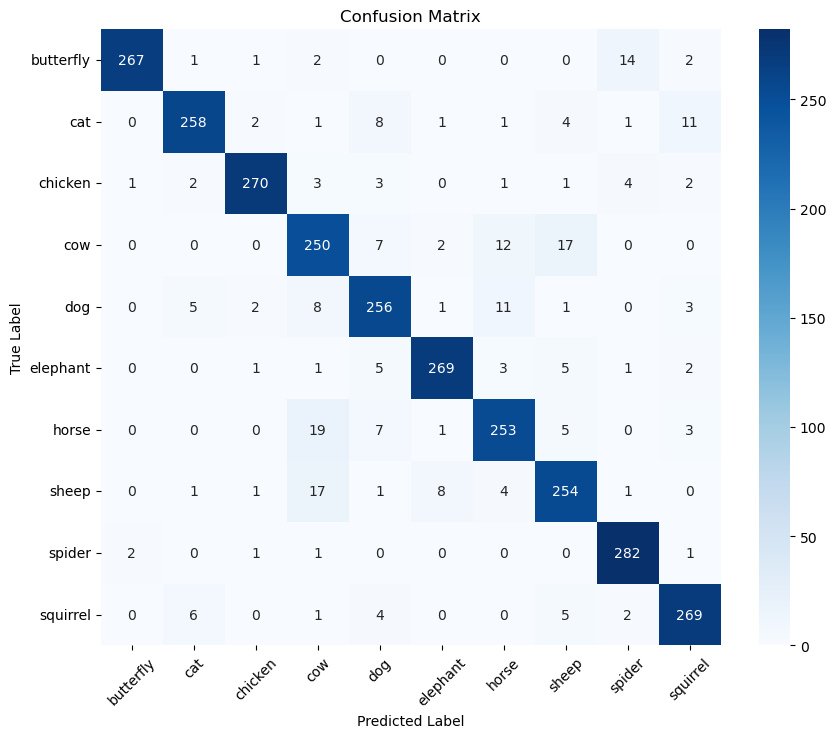

In [41]:
# Load pre-trained model
enb3_base = MobileNetV2(input_shape=(img_height, img_width, 3), alpha=1, include_top=False, weights='imagenet')
enb3_base.trainable = False  # Freeze base

# Create custom classifier
enb3_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(img_height, img_width, 3)),
    enb3_base,
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(enb3_class_names), activation='softmax')
])

# Compile the model
enb3_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
enb3_model.compile(optimizer=enb3_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stop
enb3_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=20, restore_best_weights=True )

# Train the model
history = enb3_model.fit(enb3_X["train"], enb3_y_cat["train"],
                         epochs=100, batch_size=150, 
                         validation_data=(enb3_X["test"], enb3_y_cat["test"]), callbacks=[enb3_early_stopping])

# Evaluate the model
y_pred_probs = enb3_model.predict(enb3_X["test"])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = enb3_y["test"]  # original integer labels

# Overal Model Metrics
# Compute metrics
model_compare.append({"model": "enb3_model", 
                      "accuracy_train": history.history['accuracy'][-1], 
                      "loss_train": history.history['loss'][-1], 
                      "val_accuracy_train": history.history['val_accuracy'][-1], 
                      "val_loss_train": history.history['val_loss'][-1], 
                      "accuracy_test": accuracy_score(y_true, y_pred), 
                      "precision_test": precision_score(y_true, y_pred, average='weighted'), 
                      "recall_test":recall_score(y_true, y_pred, average='weighted'), 
                      "f1-score_test":f1_score(y_true, y_pred, average='weighted')})

display(pd.DataFrame(model_compare))

# Metrics per label
print("\nLabels Details:")
print(classification_report(y_true, y_pred, target_names=enb3_class_names))

# Confusion matrix
print("\n Confusion Matrix")
plot_confusion_matrix(y_true, y_pred, enb3_class_names)

**Analysis**
- With the same architecture than the previous one but using EfficientNetV2B3 as base and changing some of the model settings I achieved an accuracy of 0.911.

In [42]:
enb3_model.save('./output/enb3_model.keras')
# Free memory before moving forward
del enb3_model, enb3_base
del enb3_optimizer, enb3_early_stopping
del enb3_X, enb3_y, enb3_y_cat, enb3_class_names
gc.collect()
tf.keras.backend.clear_session()

#### DenseNet121

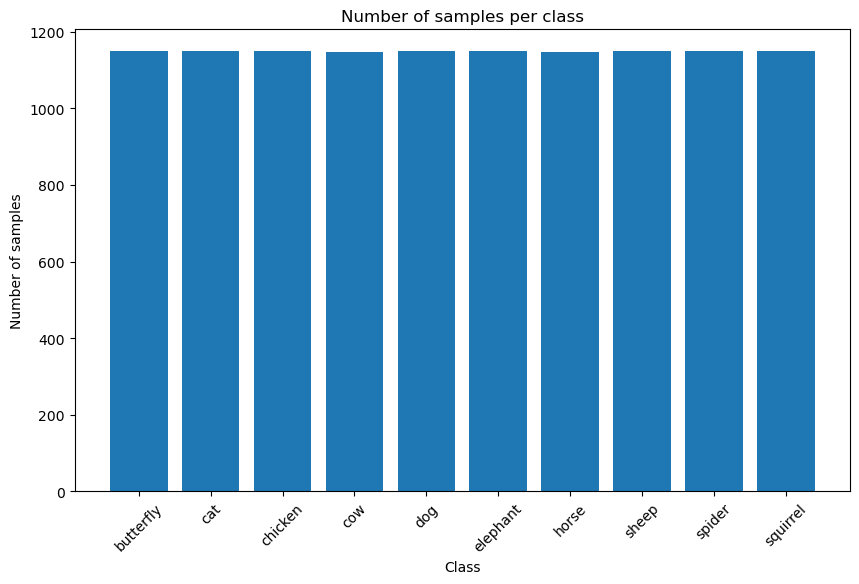

Training data shape X:  (11488, 96, 96, 3) , y: (11488, 10)
Test data shape X:  (2872, 96, 96, 3) , y: (2872, 10)


In [43]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as dn121_preprocess_input

img_height = 96
img_width  = 96

# preprocess features
dn121_X, dn121_y, dn121_y_cat, dn121_class_names = preprocess_data(df_02, path_column = "path", label_column = "label", img_width = img_width, img_height = img_height, normalizer=dn121_preprocess_input, seed = seed)

Epoch 1/10
 19/359 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3627 - loss: 2.5579

W0000 00:00:1750056879.833228     503 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750056879.836156     499 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750056879.839400     499 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750056879.843475     499 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750056879.845383     499 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7700 - loss: 0.8078 - val_accuracy: 0.8851 - val_loss: 0.3424
Epoch 2/10
  7/359 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9086 - loss: 0.2690

W0000 00:00:1750056885.454813     497 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750056885.456458     500 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750056885.457878     500 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750056885.459366     500 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1750056885.461195     500 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9113 - loss: 0.2715 - val_accuracy: 0.9081 - val_loss: 0.2921
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9420 - loss: 0.1753 - val_accuracy: 0.8952 - val_loss: 0.3177
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9576 - loss: 0.1261 - val_accuracy: 0.9032 - val_loss: 0.3138
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9692 - loss: 0.0929 - val_accuracy: 0.9095 - val_loss: 0.3235
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9750 - loss: 0.0737 - val_accuracy: 0.9140 - val_loss: 0.3405
Epoch 7/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9817 - loss: 0.0587 - val_accuracy: 0.9067 - val_loss: 0.3951
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9787 - loss: 0.0609 - val_accuracy: 0.9112 - val_loss: 0.3854
Epoch 9/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9782 - loss: 0.0613 - val_accuracy: 0.905

,model,accuracy_train,loss_train,val_accuracy_train,val_loss_train,accuracy_test,precision_test,recall_test,f1-score_test
0,model_01,0.830999,0.521517,0.501729,1.815209,0.529046,0.560268,0.529046,0.532693
1,model_02,0.806146,0.611757,0.498607,1.881110,0.521936,0.542052,0.521936,0.520516
2,model_03,0.501480,1.431633,0.544916,1.328481,0.564415,0.560131,0.564415,0.553063
3,model_04,0.642671,1.019825,0.701253,0.995752,0.702646,0.712956,0.702646,0.699232
4,mnv2_model,0.989815,0.032202,0.926880,0.416603,0.931058,0.932087,0.931058,0.931222
5,mnv2_model (fine tune),0.971382,0.094761,0.970409,0.106102,0.936630,0.936988,0.936630,0.936687
6,enb3_model,1.000000,0.002064,0.916086,0.369216,0.915042,0.916372,0.915042,0.915362
7,dn121_model,0.982852,0.049107,0.903552,0.482274,0.908078,0.910481,0.908078,0.908263



Labels Details:
              precision    recall  f1-score   support

   butterfly       0.96      0.96      0.96       287
         cat       0.98      0.87      0.92       287
     chicken       0.98      0.90      0.94       287
         cow       0.83      0.85      0.84       288
         dog       0.84      0.93      0.88       287
    elephant       0.89      0.95      0.92       287
       horse       0.88      0.88      0.88       288
       sheep       0.90      0.83      0.86       287
      spider       0.96      0.96      0.96       287
    squirrel       0.88      0.96      0.92       287

    accuracy                           0.91      2872
   macro avg       0.91      0.91      0.91      2872
weighted avg       0.91      0.91      0.91      2872


 Confusion Matrix


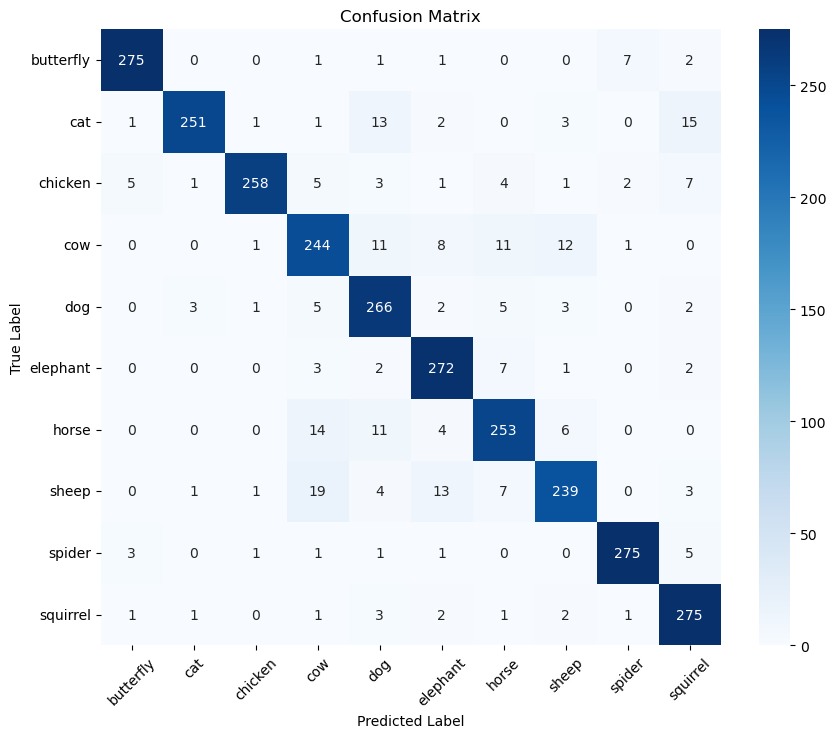

In [44]:
# Load pre-trained model
dn121_base = DenseNet121(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet', classes=len(dn121_class_names))
dn121_base.trainable = False  # Freeze base

# Create custom classifier
dn121_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(img_height, img_width, 3)),
    dn121_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dense(len(dn121_class_names), activation='softmax') 
])

# Compile the model
dn121_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
dn121_model.compile(optimizer=dn121_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stop
dn121_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10, restore_best_weights=True )

# Train the model
history = dn121_model.fit(dn121_X["train"], dn121_y_cat["train"],
                       epochs=10, batch_size=32, 
                       validation_data=(dn121_X["test"], dn121_y_cat["test"]), callbacks=[dn121_early_stopping])

# Evaluate the model
y_pred_probs = dn121_model.predict(dn121_X["test"])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = dn121_y["test"]  # original integer labels

# Overal Model Metrics
# Compute metrics
model_compare.append({"model": "dn121_model", 
                      "accuracy_train": history.history['accuracy'][-1], 
                      "loss_train": history.history['loss'][-1], 
                      "val_accuracy_train": history.history['val_accuracy'][-1], 
                      "val_loss_train": history.history['val_loss'][-1], 
                      "accuracy_test": accuracy_score(y_true, y_pred), 
                      "precision_test": precision_score(y_true, y_pred, average='weighted'), 
                      "recall_test":recall_score(y_true, y_pred, average='weighted'), 
                      "f1-score_test":f1_score(y_true, y_pred, average='weighted')})

display(pd.DataFrame(model_compare))

# Metrics per label
print("\nLabels Details:")
print(classification_report(y_true, y_pred, target_names=dn121_class_names))

# Confusion matrix
print("\n Confusion Matrix")
plot_confusion_matrix(y_true, y_pred, dn121_class_names)

**Analysis**
- With the same architecture than MobileNetV2 and the settings of EfficientNetV2B3, Using the model DenseNet121  I achieved an accuracy of 0.897.

In [45]:
dn121_model.save('./output/dn121_model.keras')
# Free memory before moving forward
del dn121_model, dn121_base
del dn121_optimizer, dn121_early_stopping
del dn121_X, dn121_y, dn121_y_cat, dn121_class_names
gc.collect()
tf.keras.backend.clear_session()

## Model Comparison

,model,accuracy_train,loss_train,val_accuracy_train,val_loss_train,accuracy_test,precision_test,recall_test,f1-score_test
0,model_01,0.830999,0.521517,0.501729,1.815209,0.529046,0.560268,0.529046,0.532693
1,model_02,0.806146,0.611757,0.498607,1.881110,0.521936,0.542052,0.521936,0.520516
2,model_03,0.501480,1.431633,0.544916,1.328481,0.564415,0.560131,0.564415,0.553063
3,model_04,0.642671,1.019825,0.701253,0.995752,0.702646,0.712956,0.702646,0.699232
4,mnv2_model,0.989815,0.032202,0.926880,0.416603,0.931058,0.932087,0.931058,0.931222
5,mnv2_model (fine tune),0.971382,0.094761,0.970409,0.106102,0.936630,0.936988,0.936630,0.936687
6,enb3_model,1.000000,0.002064,0.916086,0.369216,0.915042,0.916372,0.915042,0.915362
7,dn121_model,0.982852,0.049107,0.903552,0.482274,0.908078,0.910481,0.908078,0.908263


<Axes: xlabel='model'>

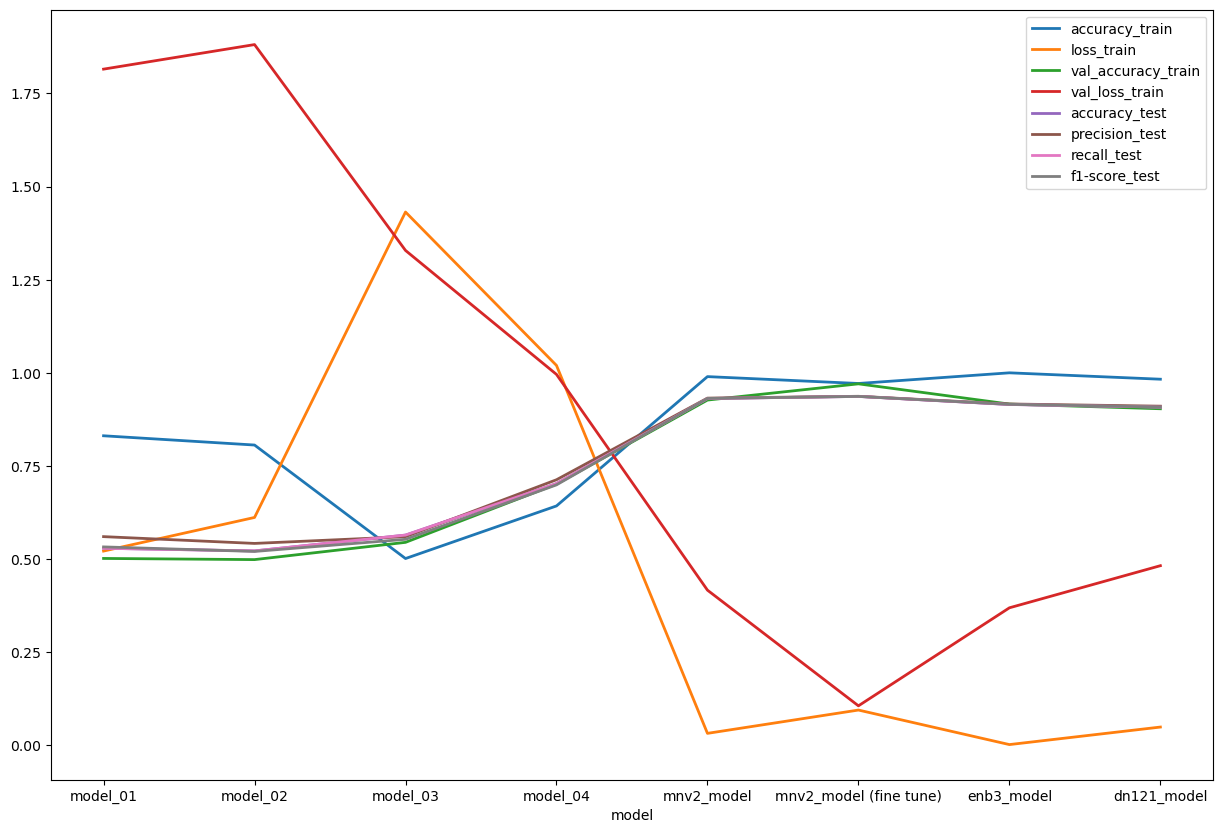

In [46]:
results = pd.DataFrame(model_compare) 

display(results)
results.plot(x="model", figsize=(15, 10), linewidth= 2)